In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle

In [33]:
import torch
torch.__version__

'1.7.1'

In [34]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision.transforms import transforms

In [35]:
def get_train_labels(train_label):
    for i,num in enumerate(train_label):
        if(num> 4.5):
            train_label[i] = 1
        else:
            train_label[i]= 0
            
    return train_label

In [36]:
fourier_dataset = pickle.load(open("../../Dataset/RelativeEnergyData/fourier_realtive_energy_data.pkl","rb"))
wavelet_dataset = pickle.load(open("../../Dataset/RelativeEnergyData/wavelet_realtive_energy_data.pkl","rb"))

In [37]:
final_merged=np.concatenate((fourier_dataset,wavelet_dataset), axis=1)

In [38]:
final_merged.shape

(396, 140)

In [39]:
X = final_merged
arousal_label = pickle.load(open("../../Dataset/UserLabels.pkl","rb"))[:,:1][:396]
valence_label = pickle.load(open("../../Dataset/UserLabels.pkl","rb"))[:, 1:2][:396]
dominance_label = pickle.load(open("../../Dataset/UserLabels.pkl","rb"))[:,2:3][:396]
liking_label = pickle.load(open("../../Dataset/UserLabels.pkl","rb"))[:,3:4][:396]

In [40]:
X = X.astype(float)
arousal_label = arousal_label.astype(float)
valence_label = valence_label.astype(float)
dominance_label = dominance_label.astype(float)
liking_label = liking_label.astype(float)

In [41]:
# clean data
def clean_data(dataset, target):
    del_rows = []
    for i in range(len(dataset)):
        if(np.isnan(dataset[i]).sum() > 0):
            del_rows.append(i)
            
    dataset = np.delete(dataset, del_rows, axis=0)
    target = np.delete(target, del_rows, axis=0)
    
    return dataset,target

In [42]:
arousal_dataset,arousal_labels = clean_data(X,arousal_label)
valence_dataset,valence_labels = clean_data(X,valence_label)
dominance_dataset ,dominance_labels = clean_data(X,dominance_label)
liking_dataset,liking_labels = clean_data(X,liking_label)

In [43]:
arousal_labels = get_train_labels(arousal_labels) 
valence_labels = get_train_labels(valence_labels)
dominance_labels = get_train_labels(dominance_labels)
liking_labels = get_train_labels(liking_labels)

In [44]:
class STFT(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(1,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            nn.Conv1d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            nn.AdaptiveAvgPool1d(1),

            nn.Flatten(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,1),
            nn.Sigmoid()
    )

    def forward(self,xb):
        out = self.network(xb)
        return out
  
    def training_step(self,batch):
        features,label = batch
        out = self(features)
        loss = F.binary_cross_entropy(out,label)
        return loss

    def validation_step(self,batch):
        features,label = batch
        out = self(features)
        loss = F.binary_cross_entropy(out,label)
        acc = accuracy(out,label)
        return {"val_loss": loss.detach(),"val_acc": acc}

    def validation_epoch_end(self,outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(),"val_acc":epoch_acc.item()}

    def epoch_end(self,num_epoch,results):
        print("num_epoch: {}, train_loss: {:.2f}, val_loss: {:.2f}, val_acc: {:.2f}".format(num_epoch+1,results['train_loss'],results['val_loss'], results['val_acc']))

In [45]:
def accuracy(out,label):
    out = (out>0.5)
    pred = (out == label).sum()
    return pred/out.shape[0]

def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(num_epochs,lr,train_loader,val_loader,model,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),lr)
    history = []
    for epoch in range(num_epochs):
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        results = evaluate(model,val_loader)
        train_loss = torch.stack(train_losses).mean().item()
        results['train_loss'] = train_loss
        model.epoch_end(epoch,results)
        history.append(results)
    return history

In [46]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
def get_plot(history):
    final_train_loss=[]
    final_val_loss=[]
    final_val_acc=[]
    
    for i in history:
        final_train_loss.append(i['train_loss'])
        final_val_loss.append(i['val_loss'])
        final_val_acc.append(i['val_acc'])
        
    epochs=len(history)
    
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 2, 1)
    plt.title("Epochs vs Loss", fontsize=15)
    plt.plot(list(np.arange(epochs) + 1) , final_train_loss, label='Train')
    plt.plot(list(np.arange(epochs) + 1), final_val_loss, label='Validation')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(loc='best')
    
    ax = fig.add_subplot(1, 2, 2)
    plt.title("Epochs vs Accuracy")
    plt.plot(list(np.arange(epochs) + 1) ,final_val_acc)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.legend(loc='best')

# Splitting the Dataset and Training

In [47]:
x_a_train,x_a_test,y_a_train,y_a_test=train_test_split(arousal_dataset,np.array(arousal_labels), test_size=0.3,random_state=42)
x_v_train,x_v_test,y_v_train,y_v_test=train_test_split(valence_dataset,np.array(valence_labels), test_size=0.3,random_state=42)
x_d_train,x_d_test,y_d_train,y_d_test = train_test_split(dominance_dataset,np.array(dominance_labels),test_size = 0.3,random_state = 42)
x_l_train,x_l_test,y_l_train,y_l_test = train_test_split(liking_dataset,np.array(liking_labels),test_size = 0.3,random_state = 42)

In [48]:
scaler = StandardScaler()
x_a_train = scaler.fit_transform(x_a_train)
x_a_test = scaler.fit_transform(x_a_test)

x_v_train = scaler.fit_transform(x_v_train)
x_v_test = scaler.fit_transform(x_v_test)

x_d_train = scaler.fit_transform(x_d_train)
x_d_test = scaler.fit_transform(x_d_test)

x_l_train = scaler.fit_transform(x_l_train)
x_l_test = scaler.fit_transform(x_l_test)

In [49]:
train_a_tensor = torch.tensor(x_a_train,dtype=torch.float32)
train_a_label = torch.tensor(y_a_train,dtype=torch.float32)

test_a_tensor =torch.tensor(x_a_test,dtype=torch.float32)
test_a_label = torch.tensor(y_a_test,dtype=torch.float32)


train_v_tensor = torch.tensor(x_v_train,dtype=torch.float32)
train_v_label = torch.tensor(y_v_train,dtype=torch.float32)

test_v_tensor =torch.tensor(x_v_test,dtype=torch.float32)
test_v_label = torch.tensor(y_v_test,dtype=torch.float32)

train_d_tensor = torch.tensor(x_d_train,dtype=torch.float32)
train_d_label = torch.tensor(y_d_train,dtype=torch.float32)

test_d_tensor =torch.tensor(x_d_test,dtype=torch.float32)
test_d_label = torch.tensor(y_d_test,dtype=torch.float32)

train_l_tensor = torch.tensor(x_l_train,dtype=torch.float32)
train_l_label = torch.tensor(y_l_train,dtype=torch.float32)

test_l_tensor =torch.tensor(x_l_test,dtype=torch.float32)
test_l_label = torch.tensor(y_l_test,dtype=torch.float32)

In [50]:
train_a_tensor=train_a_tensor.reshape(train_a_tensor.shape[0],1,140)
test_a_tensor=test_a_tensor.reshape(test_a_tensor.shape[0],1,140)

train_v_tensor=train_v_tensor.reshape(train_v_tensor.shape[0],1,140)
test_v_tensor=test_v_tensor.reshape(test_v_tensor.shape[0],1,140)

train_d_tensor=train_d_tensor.reshape(train_d_tensor.shape[0],1,140)
test_d_tensor=test_d_tensor.reshape(test_d_tensor.shape[0],1,140)

train_l_tensor=train_l_tensor.reshape(train_l_tensor.shape[0],1,140)
test_l_tensor=test_l_tensor.reshape(test_l_tensor.shape[0],1,140)

In [51]:
print("Train Tensor shape",train_a_tensor.shape)
print("Test Tensor shape",test_a_tensor.shape)
print("Train Tensor shape",train_d_tensor.shape)
print("Test Tensor shape",test_l_tensor.shape)

Train Tensor shape torch.Size([275, 1, 140])
Test Tensor shape torch.Size([118, 1, 140])
Train Tensor shape torch.Size([275, 1, 140])
Test Tensor shape torch.Size([118, 1, 140])


In [52]:
train_arousal = TensorDataset(train_a_tensor, train_a_label)
test_arousal = TensorDataset(test_a_tensor, test_a_label)

train_valence = TensorDataset(train_v_tensor, train_v_label)
test_valence =TensorDataset(test_v_tensor, test_v_label)

train_dominance = TensorDataset(train_d_tensor, train_d_label)
test_dominance =TensorDataset(test_d_tensor, test_d_label)

train_liking = TensorDataset(train_l_tensor, train_l_label)
test_liking =TensorDataset(test_l_tensor, test_l_label)

In [53]:
val_size = int(0.2 * len(train_arousal))
train_size = len(train_arousal) - val_size

train_a_ds,val_a_ds = random_split(train_arousal,[train_size,val_size])

train_v_ds,val_v_ds = random_split(train_valence,[train_size,val_size])

train_d_ds,val_d_ds = random_split(train_dominance,[train_size,val_size])

train_l_ds,val_l_ds = random_split(train_liking,[train_size,val_size])

In [54]:
device = get_default_device()
device

device(type='cpu')

In [55]:
batch_size = 32
train_arousal_loader =  DataLoader(train_a_ds,batch_size=batch_size,shuffle=True)
val_arousal_loader =  DataLoader(val_a_ds,batch_size=batch_size,shuffle=True)
test_arousal_loader =  DataLoader(test_arousal,batch_size=batch_size,shuffle=True)

batch_size = 32
train_valence_loader =  DataLoader(train_v_ds,batch_size=batch_size,shuffle=True)
val_valence_loader =  DataLoader(val_v_ds,batch_size=batch_size,shuffle=True)
test_valence_loader =  DataLoader(test_valence,batch_size=batch_size,shuffle=True)

batch_size = 32
train_dominance_loader =  DataLoader(train_d_ds,batch_size=batch_size,shuffle=True)
val_dominance_loader =  DataLoader(val_d_ds,batch_size=batch_size,shuffle=True)
test_dominance_loader =  DataLoader(test_dominance,batch_size=batch_size,shuffle=True)

batch_size = 32
train_liking_loader =  DataLoader(train_l_ds,batch_size=batch_size,shuffle=True)
val_liking_loader =  DataLoader(val_l_ds,batch_size=batch_size,shuffle=True)
test_liking_loader =  DataLoader(test_liking,batch_size=batch_size,shuffle=True)

In [56]:
train_arousal_loader=DeviceDataLoader(train_arousal_loader,device)
val_arousal_loader=DeviceDataLoader(val_arousal_loader,device)
test_arousal_loader=DeviceDataLoader(test_arousal_loader,device)


train_valence_loader = DeviceDataLoader(train_valence_loader,device)
val_valence_loader = DeviceDataLoader(val_valence_loader,device)
test_valence_loader = DeviceDataLoader(test_valence_loader,device)

train_dominance_loader = DeviceDataLoader(train_dominance_loader,device)
val_dominance_loader = DeviceDataLoader(val_dominance_loader,device)
test_dominance_loader = DeviceDataLoader(test_dominance_loader,device)

train_liking_loader = DeviceDataLoader(train_liking_loader,device)
val_liking_loader = DeviceDataLoader(val_liking_loader,device)
test_liking_loader = DeviceDataLoader(test_liking_loader,device)

# **AROUSAL:-**

In [57]:
arousal_model= STFT()
arousal_model= arousal_model.to(device)

In [58]:
history = fit(10,0.001,train_arousal_loader,val_arousal_loader,arousal_model)

num_epoch: 1, train_loss: 0.66, val_loss: 0.68, val_acc: 0.60
num_epoch: 2, train_loss: 0.60, val_loss: 0.64, val_acc: 0.59
num_epoch: 3, train_loss: 0.59, val_loss: 0.64, val_acc: 0.64
num_epoch: 4, train_loss: 0.57, val_loss: 0.66, val_acc: 0.62
num_epoch: 5, train_loss: 0.55, val_loss: 0.67, val_acc: 0.65
num_epoch: 6, train_loss: 0.53, val_loss: 0.68, val_acc: 0.63
num_epoch: 7, train_loss: 0.51, val_loss: 0.70, val_acc: 0.64
num_epoch: 8, train_loss: 0.48, val_loss: 0.63, val_acc: 0.63
num_epoch: 9, train_loss: 0.45, val_loss: 0.72, val_acc: 0.62
num_epoch: 10, train_loss: 0.43, val_loss: 0.67, val_acc: 0.68


No handles with labels found to put in legend.


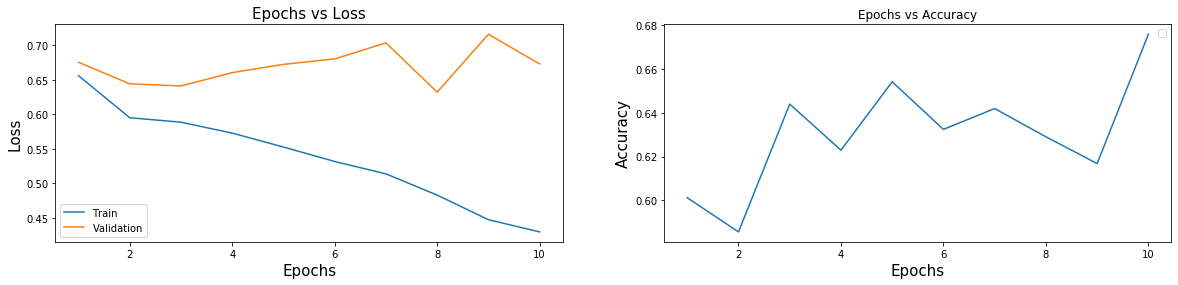

In [59]:
get_plot(history)

In [60]:
evaluate(arousal_model,test_arousal_loader)

{'val_loss': 0.7162854075431824, 'val_acc': 0.6186079382896423}

# **VALENCE:-**

In [61]:
valence_model= STFT()
valence_model= valence_model.to(device)

In [62]:
history = fit(10,0.001,train_valence_loader,val_valence_loader,valence_model)

num_epoch: 1, train_loss: 0.68, val_loss: 0.73, val_acc: 0.52
num_epoch: 2, train_loss: 0.67, val_loss: 0.70, val_acc: 0.53
num_epoch: 3, train_loss: 0.67, val_loss: 0.70, val_acc: 0.54
num_epoch: 4, train_loss: 0.66, val_loss: 0.72, val_acc: 0.52
num_epoch: 5, train_loss: 0.66, val_loss: 0.73, val_acc: 0.47
num_epoch: 6, train_loss: 0.64, val_loss: 0.74, val_acc: 0.42
num_epoch: 7, train_loss: 0.63, val_loss: 0.80, val_acc: 0.53
num_epoch: 8, train_loss: 0.62, val_loss: 0.75, val_acc: 0.39
num_epoch: 9, train_loss: 0.61, val_loss: 0.80, val_acc: 0.46
num_epoch: 10, train_loss: 0.60, val_loss: 0.80, val_acc: 0.37


No handles with labels found to put in legend.


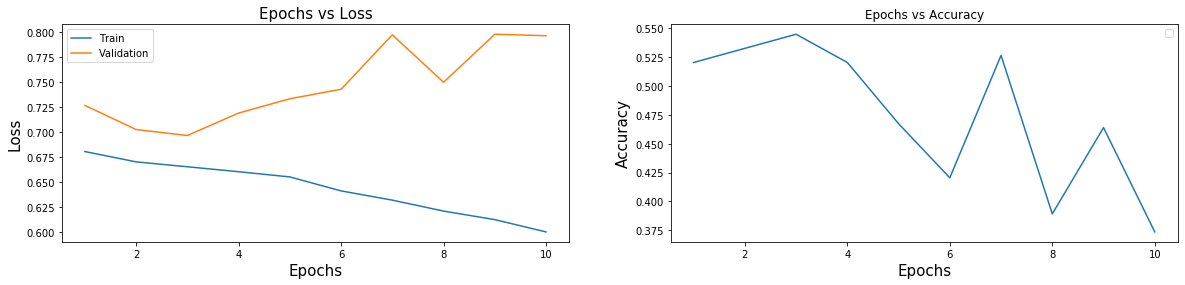

In [63]:
get_plot(history)

In [64]:
evaluate(valence_model,test_valence_loader)

{'val_loss': 0.6775728464126587, 'val_acc': 0.5617897510528564}

# **DOMINANCE:-**

In [65]:
dominance_model= STFT()
dominance_model= dominance_model.to(device)

In [66]:
history = fit(10,0.001,train_dominance_loader,val_dominance_loader,dominance_model)

num_epoch: 1, train_loss: 0.70, val_loss: 0.71, val_acc: 0.53
num_epoch: 2, train_loss: 0.68, val_loss: 0.72, val_acc: 0.41
num_epoch: 3, train_loss: 0.67, val_loss: 0.71, val_acc: 0.46
num_epoch: 4, train_loss: 0.65, val_loss: 0.69, val_acc: 0.58
num_epoch: 5, train_loss: 0.64, val_loss: 0.71, val_acc: 0.56
num_epoch: 6, train_loss: 0.61, val_loss: 0.71, val_acc: 0.51
num_epoch: 7, train_loss: 0.58, val_loss: 0.79, val_acc: 0.57
num_epoch: 8, train_loss: 0.54, val_loss: 0.75, val_acc: 0.63
num_epoch: 9, train_loss: 0.49, val_loss: 0.83, val_acc: 0.59
num_epoch: 10, train_loss: 0.45, val_loss: 0.69, val_acc: 0.55


No handles with labels found to put in legend.


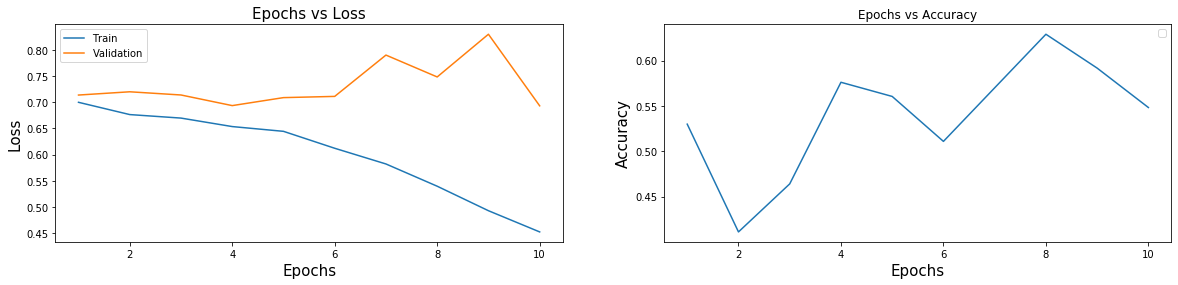

In [67]:
get_plot(history)

In [68]:
evaluate(dominance_model,test_dominance_loader)

{'val_loss': 0.7011376023292542, 'val_acc': 0.5887783765792847}

# **LIKING:-**

In [69]:
liking_model= STFT()
liking_model= liking_model.to(device)

In [70]:
history = fit(10,0.001,train_liking_loader,val_liking_loader,liking_model)

num_epoch: 1, train_loss: 0.56, val_loss: 0.80, val_acc: 0.64
num_epoch: 2, train_loss: 0.54, val_loss: 0.71, val_acc: 0.63
num_epoch: 3, train_loss: 0.53, val_loss: 0.74, val_acc: 0.63
num_epoch: 4, train_loss: 0.53, val_loss: 0.75, val_acc: 0.63
num_epoch: 5, train_loss: 0.51, val_loss: 0.71, val_acc: 0.63
num_epoch: 6, train_loss: 0.49, val_loss: 0.71, val_acc: 0.64
num_epoch: 7, train_loss: 0.47, val_loss: 0.79, val_acc: 0.62
num_epoch: 8, train_loss: 0.49, val_loss: 0.78, val_acc: 0.63
num_epoch: 9, train_loss: 0.46, val_loss: 0.79, val_acc: 0.56
num_epoch: 10, train_loss: 0.42, val_loss: 0.87, val_acc: 0.62


No handles with labels found to put in legend.


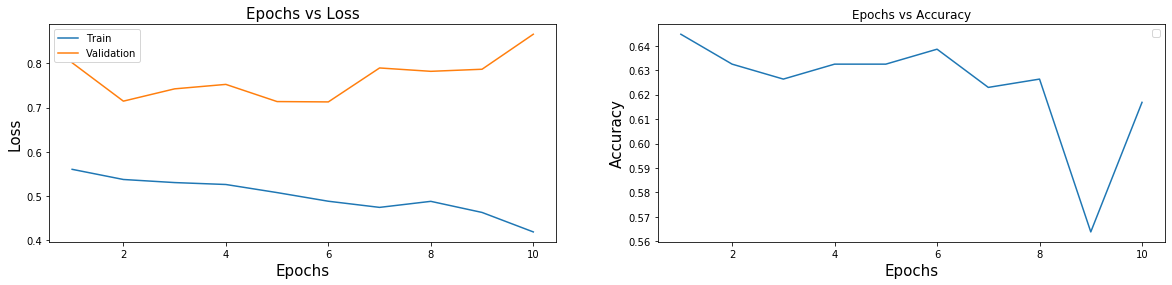

In [71]:
get_plot(history)

In [72]:
evaluate(liking_model,test_liking_loader)

{'val_loss': 0.6747807264328003, 'val_acc': 0.7244318127632141}